In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
%matplotlib inline

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data_path = os.path.join(str(os.getcwd()), '..', 'data')
df = pd.read_csv(os.path.join(data_path, "training_set.csv.zip"))
df_meta = pd.read_csv(os.path.join(data_path, "training_set_metadata.csv"))

In [3]:
df_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


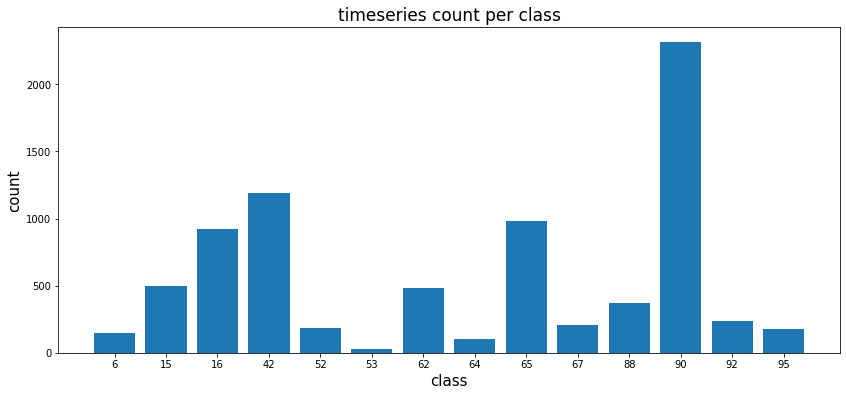

In [4]:
def plot_labels(class_count, title="timeseries count per class"):
    labels_cc, values_cc = zip(*sorted(class_count.items()))
    indexes = np.arange(len(labels_cc))
    fig = plt.figure(figsize=(14, 6))
    plt.bar(indexes, values_cc)
    plt.xticks(indexes, labels_cc)
    plt.xlabel("class", fontsize=15)
    plt.ylabel("count", fontsize=15)
    plt.title(title, fontsize=17)


class_count = defaultdict(int)
for l in df_meta["target"]:
    class_count[l] += 1
    
plot_labels(class_count)

In [62]:
def get_timeseries_detections(df, df_meta, passband=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    labels = []
    dataset = []
    times = []
    total_detected = []
    six_or_more_detections = 0
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        
        tot_detect = np.sum(detections.loc[object_id])
        if tot_detect >= 6:
            six_or_more_detections += 1
        
        labels.append(target)
        dataset.append(np.array(fluxes.loc[object_id]))
        times.append(np.array(mjds.loc[object_id]))
        total_detected.append(tot_detect)
    return dataset, times, labels, total_detected, six_or_more_detections

passband = 5
d_before, t_before, l_before, total_detected, six_or_more = get_timeseries_detections(df, df_meta, passband=passband)

In [64]:
print(six_or_more, len(d_before))

1490 7848


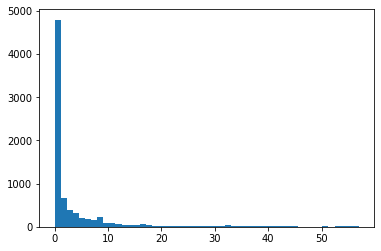

In [10]:
_ = plt.hist(total_detected, bins=50)

total detection:  6
12.606405711111112 29.99082406908306 89.97247220724918
(array([40, 41, 42, 43, 44], dtype=int64),)


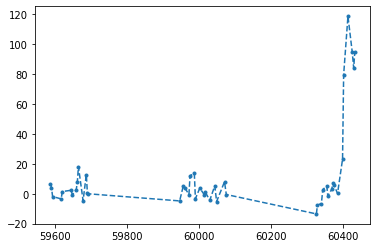

In [61]:
i = 18
print("total detection: ", total_detected[i])
plt.plot(t_before[i], d_before[i], '.--')
sigma = np.std(d_before[i])
mu = np.mean(d_before[i])
print(mu, sigma, 3*sigma)
print(np.where(np.abs(d_before[i]) > sigma))

In [59]:
np.where(np.array(total_detected, dtype=int) == 2)[0]

array([  17,   21,   41,   65,   78,   85,   95,   98,  122,  131,  142,
        180,  195,  198,  201,  230,  237,  242,  247,  248,  255,  261,
        265,  266,  274,  276,  285,  286,  304,  309,  310,  329,  336,
        343,  353,  363,  391,  400,  429,  433,  441,  457,  460,  472,
        480,  481,  488,  567,  570,  600,  601,  603,  668,  674,  696,
        698,  730,  763,  775,  797,  840,  846,  859,  862,  868,  875,
        880,  894,  923,  932,  945,  978, 1006, 1020, 1024, 1045, 1057,
       1069, 1075, 1086, 1098, 1112, 1114, 1155, 1188, 1201, 1220, 1223,
       1234, 1241, 1250, 1251, 1268, 1284, 1286, 1292, 1313, 1314, 1328,
       1340, 1355, 1386, 1387, 1398, 1413, 1414, 1422, 1429, 1431, 1434,
       1438, 1449, 1460, 1461, 1464, 1467, 1497, 1500, 1508, 1527, 1554,
       1555, 1570, 1579, 1613, 1621, 1654, 1659, 1665, 1684, 1711, 1721,
       1742, 1745, 1753, 1755, 1760, 1772, 1784, 1796, 1830, 1831, 1834,
       1842, 1855, 1858, 1860, 1869, 1875, 1899, 19

## DDF vs WDF observations

In [11]:
df_meta.groupby(by=["ddf"])["ddf"].count()

ddf
0    5732
1    2116
Name: ddf, dtype: int64

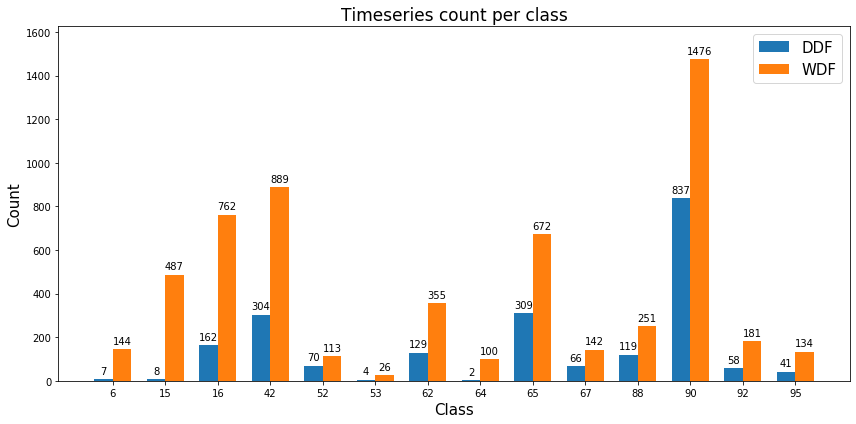

In [70]:
wdf = 0
ddf = 1

df_meta_ddf = df_meta[df_meta["ddf"] == ddf]
df_meta_wdf = df_meta[df_meta["ddf"] == wdf]

class_count_ddf = defaultdict(int)
for l in df_meta_ddf["target"]:
    class_count_ddf[l] += 1

class_count_wdf = defaultdict(int)
for l in df_meta_wdf["target"]:
    class_count_wdf[l] += 1

def plot_labels_tuple(class_count1, class_count2, label1, label2, title="Timeseries count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
    ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels_cc1)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)
    
plot_labels_tuple(class_count_ddf, class_count_wdf, "DDF", "WDF")

In [100]:
def get_timeseries(df, df_meta, passband=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    labels = []
    dataset = []
    times = []
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        labels.append(target)
        dataset.append(np.array(fluxes.loc[object_id]))
        times.append(np.array(mjds.loc[object_id]))
    return dataset, times, labels

passband = 5
d_ddf, t_ddf, l_ddf = get_timeseries(df, df_meta_ddf, passband=passband)
d_wdf, t_wdf, l_wdf = get_timeseries(df, df_meta_wdf, passband=passband)

def get_time_intervals(times):
    res = []
    for ts_t in times:
        for i in range(1, len(ts_t)):
            res.append(ts_t[i] - ts_t[i-1])
    return res

intervals_ddf = get_time_intervals(t_ddf)
intervals_wdf = get_time_intervals(t_wdf)

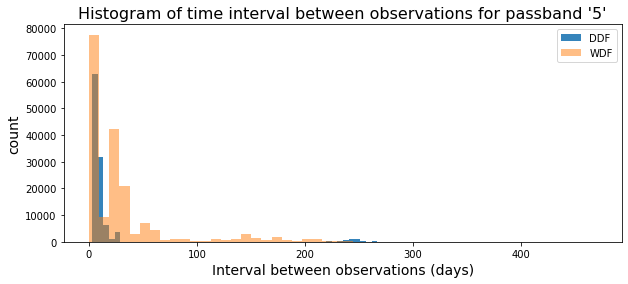

In [101]:
fig = plt.figure(figsize=(10, 4))
plt.hist(intervals_ddf, alpha=0.9, bins=50, label="DDF")
plt.hist(intervals_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Interval between observations (days)", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.title("Histogram of time interval between observations for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

In [102]:
def get_bandwidths(times):
    res = []
    for ts_t in times:
        res.append(ts_t[-1] - ts_t[0])
    return res

bandwidths_ddf = get_bandwidths(t_ddf)
bandwidths_wdf = get_bandwidths(t_wdf)

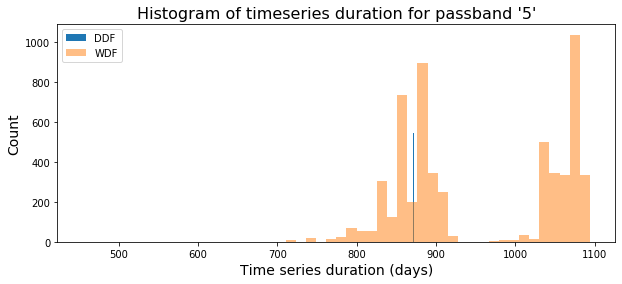

In [103]:
fig = plt.figure(figsize=(10, 4))
plt.hist(bandwidths_ddf, alpha=1, bins=50, label="DDF")
plt.hist(bandwidths_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Time series duration (days)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of timeseries duration for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

In [104]:
def get_total_samples(times):
    res = []
    for ts_t in times:
        res.append(len(ts_t))
    return res

total_samples_ddf = get_total_samples(t_ddf)
total_samples_wdf = get_total_samples(t_wdf)

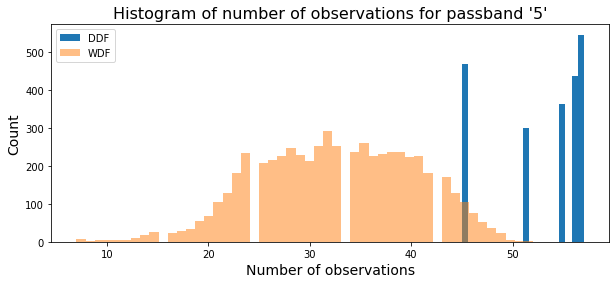

In [105]:
fig = plt.figure(figsize=(10, 4))
plt.hist(total_samples_ddf, alpha=1, bins=20, label="DDF")
plt.hist(total_samples_wdf, alpha=0.5, bins=50, label="WDF")
plt.xlabel("Number of observations", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of number of observations for passband '%s'" % passband, fontsize=16)
_ = plt.legend()

### Comments

- there are more WDF timeseries than DDF timeseries
- DDF timeseries has more observations than WDF timeseries
- DDF timeseries has lower timer intervals between observations
- classes 6, 15, 53 and  64 have less than 10 DDF timeseries
- classes 52, 67, 92, 95 have less than 100 DDF timeseries

### Working decision

- We will use classes (16, 42, 62, 65, 88, 90) for testing, discarding classes (6, 15, 52, 53, 64, 67, 92, 95). 
- We will split datasets in DDF and WDF datasets with 60% training and 40% test. 
- (optional for balancing) In addition, class 90 will be reduced to half in random way
- we will create 3 sizes dataset, using 30%, 50% and 100% of the data, in a stratify way

In [114]:
def get_reduced_stratify_dataset(dataset, labels, reduced_size, test_fraction):
    if len(dataset) - reduced_size > 10:
        _, dataset, _,  labels = train_test_split(dataset, labels,
                                                    test_size=reduced_size,
                                                    random_state=0,
                                                    stratify=labels)
    test_size = int(reduced_size * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def generate_reduced_stratify_dataset(ddf_dtl, wdf_dtl, test_fraction, dataset_ratios, output_path):
    for d_ratio in dataset_ratios:
        for dtl_set, key in zip([ddf_dtl, wdf_dtl], ["ddf", "wdf"]):
            d = dtl_set[0]
            t = dtl_set[1]
            l = dtl_set[2]
            t_d = [(t, y) for t, y in zip(t, d)]
            size = int(len(d) * d_ratio)
            train_t_d, test_t_d, train_l, test_l = get_reduced_stratify_dataset(t_d, l, 
                                                                                size, 
                                                                                test_fraction)
            train_t, train_d = zip(*train_t_d)
            test_t, test_d = zip(*test_t_d)
            skip = False
            for type_i, data_i in zip(["d", "t", "l"],
                                  [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
                out_file_train = os.path.join(output_path, "{}_train_{}_size{}.npy".format(key, type_i, size))
                out_file_test = os.path.join(output_path, "{}_test_{}_size{}.npy".format(key, type_i, size))
                
                if not os.path.exists(out_file_train):
                    np.save(out_file_train, data_i[0])
                    np.save(out_file_test, data_i[1])
                else:
                    skip = True
                    break
            if not skip:
                print(":::GEN %s dataset of size %d [%d train, %d test] on dir:" % (key, size, len(train_d), 
                                                                                      len(test_d)))
                print("::: ", output_path)
            else:
                print(":::SKIP %s dataset of size %d" % (key, size))

In [119]:
test_fraction = 0.4
dataset_ratios = [0.3, 0.5, 1]
output_path_reduced = os.path.join(data_path, "plasticc_subsets", "ddf_wdf_split_simplified", "60_40_split")

df_meta_reduced = df_meta[df_meta["target"].isin([16, 42, 62, 65, 88, 90])]

wdf = 0
ddf = 1

df_meta_reduced_ddf = df_meta_reduced[df_meta_reduced["ddf"] == ddf]
df_meta_reduced_wdf = df_meta_reduced[df_meta_reduced["ddf"] == wdf]

passband = 5
d_ddf, t_ddf, l_ddf = get_timeseries(df, df_meta_reduced_ddf, passband=passband)
d_wdf, t_wdf, l_wdf = get_timeseries(df, df_meta_reduced_wdf, passband=passband)

generate_reduced_stratify_dataset([d_ddf, t_ddf, l_ddf], [d_wdf, t_wdf, l_wdf], 
                                  test_fraction, dataset_ratios, output_path_reduced)

:::GEN ddf dataset of size 558 [335 train, 223 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 1321 [793 train, 528 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN ddf dataset of size 930 [558 train, 372 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 2202 [1322 train, 880 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN ddf dataset of size 1860 [1116 train, 744 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split
:::GEN wdf dataset of size 4405 [2643 train, 1762 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_simplified\60_40_split


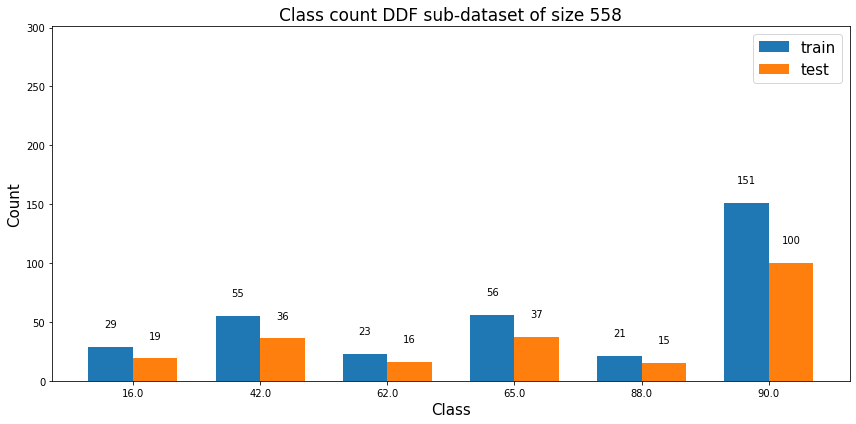

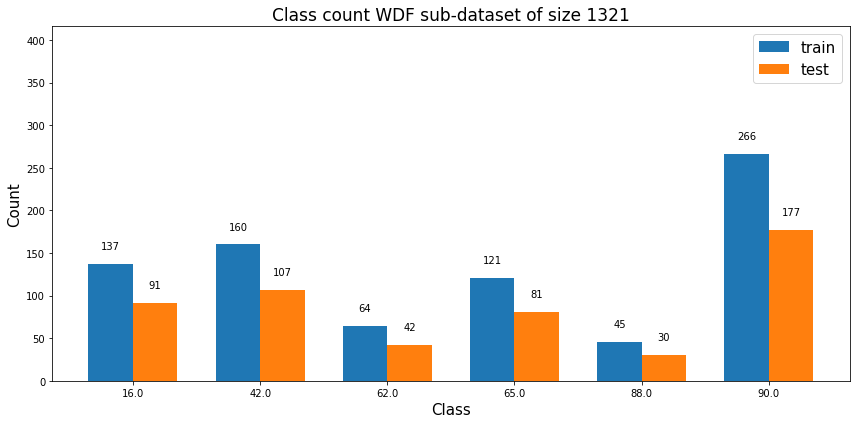

In [126]:
ddf_subset_train_l = np.load(os.path.join(output_path_reduced, "ddf_train_l_size558.npy"), allow_pickle=True)
ddf_subset_test_l = np.load(os.path.join(output_path_reduced, "ddf_test_l_size558.npy"), allow_pickle=True)
wdf_subset_train_l = np.load(os.path.join(output_path_reduced, "wdf_train_l_size1321.npy"), allow_pickle=True)
wdf_subset_test_l = np.load(os.path.join(output_path_reduced, "wdf_test_l_size1321.npy"), allow_pickle=True)

def fast_class_count_plot(train_l, test_l, title="Timeseries count per class"):
    class_count_train = defaultdict(int)
    for l in train_l:
        class_count_train[l] += 1
    class_count_test = defaultdict(int)
    for l in test_l:
        class_count_test[l] += 1
    
    plot_labels_tuple(class_count_train, class_count_test, "train", "test", title=title)
    
fast_class_count_plot(ddf_subset_train_l, ddf_subset_test_l, title="Class count DDF sub-dataset of size 558")
fast_class_count_plot(wdf_subset_train_l, wdf_subset_test_l, title="Class count WDF sub-dataset of size 1321")

## Detection meta

we can see that original dataset includes a detection/non-detection feature and that most of the single-band time series has 0 detections, so we can create a single-band dataset using only time series with a minimum number of detections

In [71]:
# we take time series with at least 'min_detections' detections in this band
def get_timeseries_detections(df, df_meta, passband=3, min_detections=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    labels = []
    dataset = []
    times = []
    total_detected = []
    ddf_target = []
    wdf_target = []
    
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        tot_detect = np.sum(detections.loc[object_id])
        if tot_detect >= min_detections:
            labels.append(target)
            dataset.append(np.array(fluxes.loc[object_id]))
            times.append(np.array(mjds.loc[object_id]))
            total_detected.append(tot_detect)
            
            if row.ddf:
                ddf_target.append(target)
            else:
                wdf_target.append(target)
                
    return dataset, times, labels, total_detected, ddf_target, wdf_target

passband = 5
d_before, t_before, l_before, total_detected, ddf_target, wdf_target = get_timeseries_detections(df, df_meta, passband=passband)

In [76]:
print(len(total_detected), len(ddf_target), len(wdf_target))

2402 1206 1196


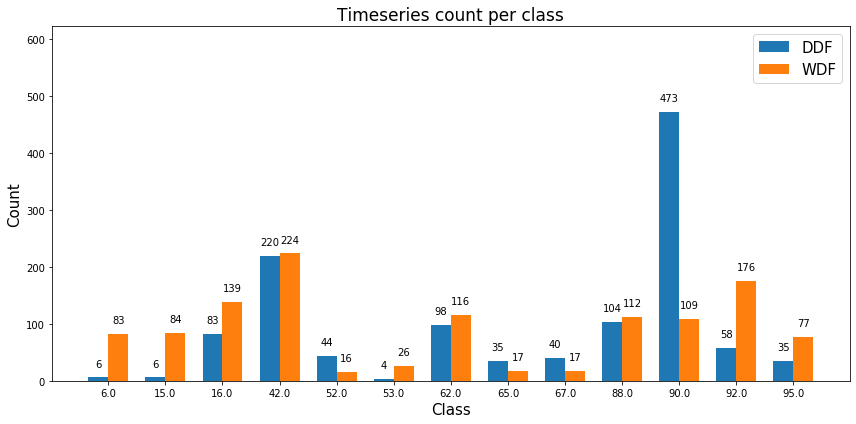

In [73]:
class_count_ddf = defaultdict(int)
for l in ddf_target:
    class_count_ddf[l] += 1

class_count_wdf = defaultdict(int)
for l in wdf_target:
    class_count_wdf[l] += 1
    
def plot_labels_tuple(class_count1, class_count2, label1, label2, title="Timeseries count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
    ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels_cc1)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    
plot_labels_tuple(class_count_ddf, class_count_wdf, "DDF", "WDF")

from this setup, we keep classes: 16, 42, 62, 88, 92

In [81]:
def get_reduced_stratify_dataset(dataset, labels, reduced_size, test_fraction):
    if len(dataset) - reduced_size > 10:
        _, dataset, _,  labels = train_test_split(dataset, labels,
                                                    test_size=reduced_size,
                                                    random_state=0,
                                                    stratify=labels)
    test_size = int(reduced_size * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def generate_reduced_stratify_dataset(ddf_dtl, wdf_dtl, test_fraction, dataset_ratios, output_path):
    for d_ratio in dataset_ratios:
        for dtl_set, key in zip([ddf_dtl, wdf_dtl], ["ddf", "wdf"]):
            d = dtl_set[0]
            t = dtl_set[1]
            l = dtl_set[2]
            t_d = [(t, y) for t, y in zip(t, d)]
            size = int(len(d) * d_ratio)
            train_t_d, test_t_d, train_l, test_l = get_reduced_stratify_dataset(t_d, l, 
                                                                                size, 
                                                                                test_fraction)
            train_t, train_d = zip(*train_t_d)
            test_t, test_d = zip(*test_t_d)
            skip = False
            for type_i, data_i in zip(["d", "t", "l"],
                                  [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
                out_file_train = os.path.join(output_path, "{}_train_{}_size{}.npy".format(key, type_i, size))
                out_file_test = os.path.join(output_path, "{}_test_{}_size{}.npy".format(key, type_i, size))
                
                if not os.path.exists(out_file_train):
                    np.save(out_file_train, data_i[0])
                    np.save(out_file_test, data_i[1])
                else:
                    skip = True
                    break
            if not skip:
                print(":::GEN %s dataset of size %d [%d train, %d test] on dir:" % (key, size, len(train_d), 
                                                                                      len(test_d)))
                print("::: ", output_path)
            else:
                print(":::SKIP %s dataset of size %d" % (key, size))

In [83]:
def get_timeseries_detected(df, df_meta, passband=3, min_detections=3):
    df1 = df[df["passband"] == passband]
    df1 = df1.sort_values(by=["object_id", "mjd"])
    df_grouped = df1.groupby("object_id")
    fluxes = df_grouped["flux"].apply(list)
    mjds = df_grouped["mjd"].apply(list)
    detections = df_grouped["detected"].apply(list)
    labels = []
    dataset = []
    times = []
    total_detected = []
    
    for i in range(df_meta.shape[0]):
        row = df_meta.iloc[i]
        object_id = row.object_id
        target = row.target
        tot_detect = np.sum(detections.loc[object_id])
        if tot_detect >= min_detections:
            labels.append(target)
            dataset.append(np.array(fluxes.loc[object_id]))
            times.append(np.array(mjds.loc[object_id]))
            total_detected.append(tot_detect)
                
    return dataset, times, labels, total_detected

def get_stratify_dataset(dataset, labels, test_fraction):
    test_size = int(len(dataset) * test_fraction)
    return train_test_split(dataset, labels, test_size=test_size, random_state=0, stratify=labels)

def gen_dataset_min_detection(df, df_meta, output_path, min_detect=3, passband=5):
    df_meta_reduced2 = df_meta[df_meta["target"].isin([16, 42, 62, 88, 92])]

    wdf = 0
    ddf = 1

    for ddf in [1, 0]:
        if ddf == 1:
            key = "ddf"
        else:
            key = "wdf"
        df_meta_reduced2_type = df_meta_reduced2[df_meta_reduced2["ddf"] == ddf]
        
        d, t, l, _ = get_timeseries_detected(df, df_meta_reduced2_type, passband=passband, min_detections=min_detect)
        t_d = [(t, y) for t, y in zip(t, d)]
    
        train_t_d, test_t_d, train_l, test_l = get_stratify_dataset(t_d, l, 0.4)
    
        train_t, train_d = zip(*train_t_d)
        test_t, test_d = zip(*test_t_d)
        skip = False
        for type_i, data_i in zip(["d", "t", "l"],
                                  [(train_d, test_d), (train_t, test_t), (train_l, test_l)]):
            out_file_train = os.path.join(output_path, "{}_train_{}.npy".format(key, type_i))
            out_file_test = os.path.join(output_path, "{}_test_{}.npy".format(key, type_i))
                
            if not os.path.exists(out_file_train):
                np.save(out_file_train, data_i[0])
                np.save(out_file_test, data_i[1])
            else:
                skip = True
                break
        if not skip:
            print(":::GEN %s dataset of size %d [%d train, %d test] on dir:" % (key, len(d), len(train_d), 
                                                                                      len(test_d)))
            print("::: ", output_path)
        else:
            print(":::SKIP %s dataset of size %d" % (key, len(d)))
        
output_path_min_detect = os.path.join(data_path, "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
gen_dataset_min_detection(df, df_meta, output_path_min_detect, min_detect=3, passband=5)

:::GEN ddf dataset of size 563 [338 train, 225 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_min_detection\3_min
:::GEN wdf dataset of size 767 [461 train, 306 test] on dir:
:::  D:\tesis\tesis\notebooks\..\data\plasticc_subsets\ddf_wdf_split_min_detection\3_min


## reduction: number of classes

as a first preprocessing step, we will discard every class with less than a fixed number of time series in order to make a more simplest dataset for testing reducing the number of classes with small amount of train and test data

In [10]:
threshold = 400
df_meta = df_meta.sort_values(by=["target"])
df_meta_filtered = df_meta[df_meta['target'].map(df_meta['target'].value_counts()) >= threshold]
classes = np.unique(df_meta_filtered["target"])
print("surviving classes are:", classes)
df_meta_filtered.shape[0]

surviving classes are: [15 16 42 62 65 90]


6390

we take time series fro the passband '3'

In [11]:
passband_id = 3

df = df[df["passband"] == passband_id]
df = df.sort_values(by=["object_id", "mjd"])
df_grouped = df.groupby("object_id")
fluxes = df_grouped["flux"].apply(list)
mjds = df_grouped["mjd"].apply(list)
labels = []
dataset = []
times = []
for i in range(df_meta_filtered.shape[0]):
    row = df_meta_filtered.iloc[i]
    object_id = row.object_id
    target = row.target
    labels.append(target)
    dataset.append(np.array(fluxes.loc[object_id]))
    times.append(np.array(mjds.loc[object_id]))

### Second reduction: train/test data size

since at first we will use non-optimize solutions which will take lot of time to execute, we will start evaluating our experimentes on small sub-sets from the original dataset. From here, we will test three scenarios:

1. constant train/test set ratio but increasing the number of timeseries
2. constant test set size but increasing the size of train set
3. constant train set size but increasing the size of the test set

in particular here, for the 3rd scenario we will just have to fix the train set size and get a test size as big as posible, then on evaluation process we will take only sub-sets of this test set

for the 2nd scenario, we will fix the test set size on 1/3 of the maximum train set size

In [12]:
def get_small_dataset(dataset, times, labels, n1, n2):
    # n: size of the small dataset
    # c: use the 'c' classes most present in the original dataset
    
    data_time_tuple = [(t, y) for t, y in zip(times, dataset)]
    
    # first split, to get n1+n2 set size
    if n1+n2 < len(labels) - np.unique(labels).size:
    
         _, data_time_tuple, _,  labels = train_test_split(data_time_tuple, labels,
                                                    test_size=n1 + n2,
                                                    random_state=0,
                                                    stratify=labels)
        
    # second split, to get train n1 and test n2
    data_time_train, data_time_test, labels_train, labels_test = train_test_split(data_time_tuple,
                                                                                 labels,
                                                                                 test_size=n2,
                                                                                 random_state=0,
                                                                                 stratify=labels)
    d_train = []
    d_test = []
    t_train = []
    t_test = []
    for i in range(n1):
        t, d = data_time_train[i]
        d_train.append(d)
        t_train.append(t)
        
    for i in range(n2):
        t, d = data_time_test[i]
        d_test.append(d)
        t_test.append(t)

    
    return d_train, t_train, labels_train, d_test, t_test, labels_test


def gen_sub_sets(output_path, dataset, times, labels, n1_arr, n2_arr, c):
    for n1, n2 in zip(n1_arr, n2_arr):
        d_train, t_train, l_train, d_test, t_test, l_test = get_small_dataset(dataset, times, labels,
                                                                             n1, n2)
        skip = False
        for type_i, data_i in zip(["d", "t", "l"],
                                  [(d_train, d_test), (t_train, t_test), (l_train, l_test)]):
            out_file_train = os.path.join(output_path, "train_{}_n{}_c{}.npy".format(type_i, n1, c))
            out_file_test = os.path.join(output_path, "test_{}_n{}_c{}.npy".format(type_i, n2, c))
            if not os.path.exists(out_file_train):
                np.save(out_file_train, data_i[0])
                np.save(out_file_test, data_i[1])
            else:
                skip = True
                break
        if not skip:
            print(":::GEN [train, test, classes] = [%d, %d, %d] set on dir %s" % (n1, n2, c, output_path))
        else:
            print(":::SKIP [train, test, classes] = [%d, %d, %d]" % (n1, n2, c))

In [15]:
# 1st scenario
ratio = 2/8 # 20% test, 80% train
n1_arr = np.array([100, 500, 1000, 2000, 4000, 5000], dtype=int)
n2_arr = (n1_arr * ratio).astype(int)
output_path1 = os.path.join(data_path, "plasticc_subsets", "scenario1_ratio_2-8")
gen_sub_sets(output_path1, dataset, times, labels, n1_arr, n2_arr, len(classes))

:::GEN [train, test, classes] = [100, 25, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [500, 125, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [1000, 250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [2000, 500, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [4000, 1000, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8
:::GEN [train, test, classes] = [5000, 1250, 6] set on dir D:\tesis\tesis\notebooks\..\data\plasticc_subsets\scenario1_ratio_2-8


In [15]:
#2nd scenario

In [16]:
#3rd scenario